# Homework 7

Tempalate by: Rixin Li & G . Besla
Completed by: Jose Perez Chavez

In [125]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
import matplotlib
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# Add path to other HW folders / Modular Design
import sys
sys.path.append("../")
from Homework4.CenterOfMass import CenterOfMass
from Homework3.GalaxyMass import GalaxyMass as ComponentMass


# Setup Matplotlib preferences
# adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# M33AnalyticOrbit

In [114]:
class M33AnalyticOrbit:
    """
    Calculate the analytical orbit of M33 around M31
    
    :param filename: filepath to save output within data folder
    :param data_path: data folder where input/output files reside
    :param delta: center of mass tolerance parameter
    """
    
    def __init__(self, filename, data_path='../../Data', delta=0.1):
        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.filename = f'{data_path}/{filename}'
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33
        M33_COM = CenterOfMass(f'{data_path}/M33_VLowRes/M33_000.txt', 2)

        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        M33_COMP = M33_COM.COM_P(delta)
        
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        M33_COMV = M33_COM.COM_V(*M33_COMP)
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        M31_COM = CenterOfMass(f'{data_path}/M31_VLowRes/M31_000.txt', 2)
        
        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        M31_COMP = M31_COM.COM_P(delta)
        
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        M31_COMV = M31_COM.COM_V(*M31_COMP)
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = (M33_COMP - M31_COMP).value
        self.v0 = (M33_COMV - M31_COMV).value
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5.0
        
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass(M31_COM.data, 2) * 1e12
        
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1.0

        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass(M31_COM.data, 3) * 1e12
        
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 62.0
        
        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass(M31_COM.data, 1) * 1e12
    
    
    def HernquistAccel(self, M, r_a, r_vect): # it is easiest if you take as an input the position VECTOR 
        """ 
        Calculate the gravitational acceleration induced by a Hernquist profile
        
        :param M: total halo or bulge mass
        :param r_a: the corresponding scale length
        :param r_vect: the position vector between the galaxies
        """
        
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt( np.sum(r_vect**2) )

        ### *** Store the Acceleration
        Hern =  - self.G * M / (rmag * (r_a + rmag)**2) * r_vect
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M, rd, r_vect):# it is easiest if you take as an input a position VECTOR  r 
        """
        Calculate the gravitational acceleration induced by a Miyamoto-Nagai 1975 profile.
        
        :param M: total disk mass
        :param r_a: the disk scale length
        :param r_vect: the position vector between the galaxies
        :return: 3D acceleration vector
        """
        
        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        
        zd = rd / 5.0
        Rsq = r_vect[0]**2 + r_vect[1]**2
        z_offset = np.sqrt(r_vect[2]**2 + zd**2)
        B = rd + z_offset
        C = np.array([1, 1, B / z_offset])
        
        acc = - self.G * M * r_vect * C / (Rsq + B**2)**(1.5)
       
        return acc
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r_vect): # input should include the position vector, r
        """
        Sum of acceleration vectors from each galaxy component
        
        :param r_vect:
        :return: total acceleration
        """

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        
        bulge_acc = self.HernquistAccel(self.Mbulge, self.rbulge, r_vect)
        halo_acc = self.HernquistAccel(self.Mhalo, self.rhalo, r_vect)
        disk_acc = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r_vect)
        
        
            
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return bulge_acc + halo_acc + disk_acc
    
    
    
    def LeapFrog(self, r_old, v_old, dt): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """
        LeapFrog implementation to solve the equations of motion and compute the future orbit of M33.
        
        :param r_old: position vector to update 
        :param v_old: velocity vector to update
        :param dt: time step used for integration
        :return: r_new, v_new ; new position and velcoity vectors
        """
        
        # predict the position at the next half timestep
        rhalf = r_old + v_old * dt / 2
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        acc_half = self.M31Accel(rhalf)
        vnew = v_old + acc_half * dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + vnew * dt / 2
        
        return rnew, vnew
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """
        Orbit LeapFrog integrator for our galaxy.
        The orbit will be integrated and all data will be saved to self.filename.
        
        :param t0: initial time to start integrator at
        :param dt: timestep for integrator
        :param tmax: maximum time to integrate to
        """
        

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        steps = int(round(tmax/dt)) + 1
        orbit = np.zeros((steps, 7))
        time = t0 + np.arange(steps) * dt
        
        # initialize the first row of the orbit
        orbit[0] = t0, *self.r0, *self.v0
        orbit[:, 0] = time
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        for i in range(1, steps):  # as long as t has not exceeded the maximal time             
            # ***** Advance the position and velocity using the LeapFrog scheme
            # Store the new position & velocity vectors in the next array row
            orbit[i, 1:4], orbit[i, 4:7] = self.LeapFrog(orbit[i-1, 1:4], orbit[i-1, 4:7], dt)
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function

Run the analytic integration of the orbit, and load the saved file

In [117]:
m33_orbit = M33AnalyticOrbit('m33_analytic_orbit.txt')
m33_orbit.OrbitIntegration(0, 0.01, 10)
M33_analytic_orbit = np.genfromtxt('../../Data/m33_analytic_orbit.txt')

time_an = M33_analytic_orbit[:, 0]

Bring up the simulation orbits we created for Homework6

In [118]:
# Read in the data files for the orbits of each galaxy that you just created
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt
M31_data = np.genfromtxt('../../Data/Orbit_M31.txt')
M33_data = np.genfromtxt('../../Data/Orbit_M33.txt')

time_sim = M31_data[:, 0]/1000

In [119]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit

def VectorDiff(a, b):
    c = a - b
    return np.sqrt((c * c).sum(axis=1))

In [120]:
# Determine the magnitude of the relative position and velocities 

# M33 - M31 analytic relative position and velocities 
M33M31_an = np.sqrt((M33_analytic_orbit[:, 1:4]**2).sum(axis=1))
VM33M31_an = np.sqrt((M33_analytic_orbit[:, 4:7]**2).sum(axis=1))

# of M33 and M31 simulation relative position and velocities 
M33M31_sim = VectorDiff(M33_data[:, 1:4], M31_data[:, 1:4])
VM33M31_sim = VectorDiff(M33_data[:, 4:8], M31_data[:, 4:8])

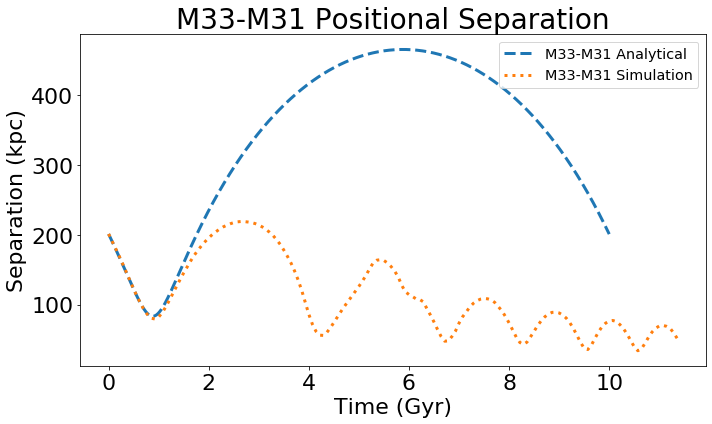

In [126]:
# Plot the Orbit of the galaxies 
#################################

# Setup canvas
fig, ax = plt.subplots(figsize=(10, 6))

# M33 - M31 analytic positional separation
ax.plot(time_an, M33M31_an, linewidth=3, ls='--', label='M33-M31 Analytical')

# M33 - M31 simulation data positional separation
ax.plot(time_sim, M33M31_sim, linewidth=3, ls=':', label='M33-M31 Simulation')

# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Separation (kpc)', fontsize=22)

# add a legend 
ax.legend(loc='upper right',fontsize='x-large')

# add a title
ax.set_title('M33-M31 Positional Separation', fontsize=28)

plt.tight_layout()